In [2]:
pip install mne mne-bids numpy pandas matplotlib scipy scikit-learn

Creating RawArray with float64 data, n_channels=64, n_times=60000
    Range : 0 ... 59999 =      0.000 ...    59.999 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Using matplotlib as 2D backend.


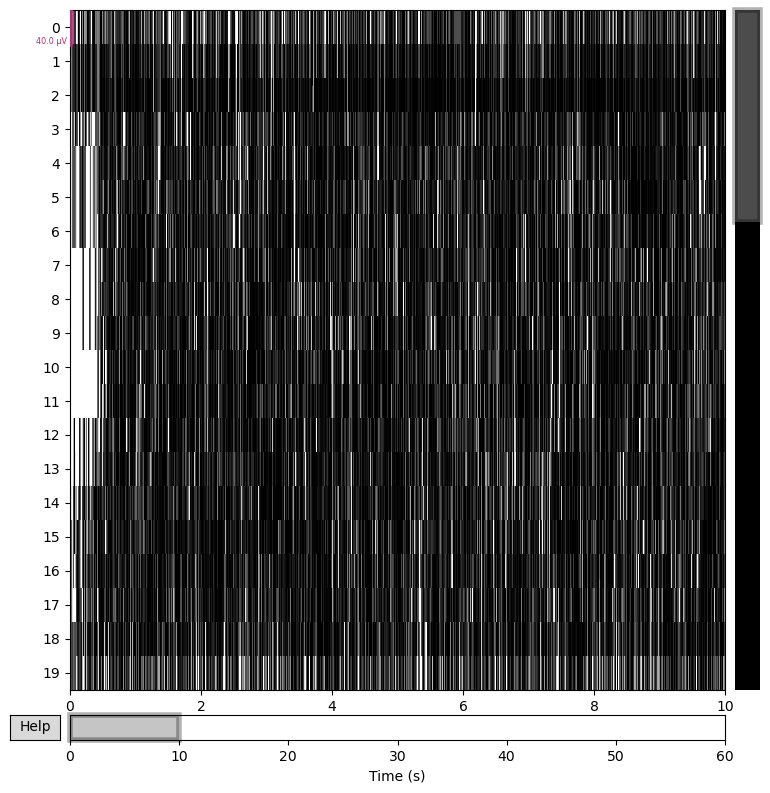

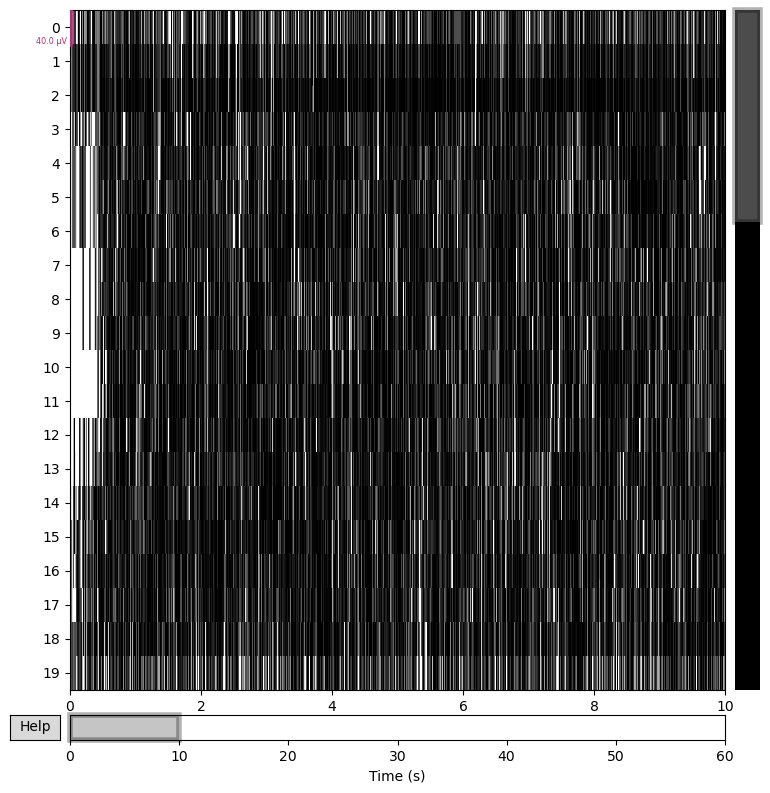

In [4]:
import mne
import numpy as np

sfreq = 1000
data = np.random.randn(64, sfreq * 60)  # 64 channels, 1 min
info = mne.create_info(64, sfreq, ch_types='eeg')
raw = mne.io.RawArray(data, info)

raw.filter(1, 40)
raw.plot()


In [5]:
import pandas as pd

edu = pd.read_csv(
    "https://www.mrc-cbu.cam.ac.uk/wp-content/uploads/cam-can/sites/9/2025/04/Derived_Years_of_Education_P1_CC3000.csv_.txt",
    na_values=["NA"]
)

# Add CC prefix
edu["participant_id"] = "CC" + edu["CCID"].astype(str)

edu = edu.rename(columns={"Years": "years_of_education"})

edu.head()

,CCID,years_of_education,participant_id
0,110019,13.0,CC110019
1,110033,16.0,CC110033
2,110037,13.0,CC110037
3,110038,18.0,CC110038
4,110045,18.0,CC110045


In [6]:
edu["years_of_education"].isna().sum()

43

In [7]:
edu["participant_id"] = "CC" + edu["CCID"].astype(str)


In [8]:
edu[edu["years_of_education"].isna()][["participant_id"]].head()


,participant_id
45,CC120009
56,CC120085
69,CC120157
70,CC120159
81,CC120262


In [9]:
edu_clean = edu.dropna(subset=["years_of_education"])


In [10]:
mean_edu = edu["years_of_education"].mean()
edu["years_of_education_filled"] = edu["years_of_education"].fillna(mean_edu)


In [11]:
edu.loc[
    edu["participant_id"].isin([
        "CC120009", "CC120085", "CC120157",
        "CC120159", "CC120262"
    ])
]


,CCID,years_of_education,participant_id,years_of_education_filled
45,120009,NaN,CC120009,14.099133
56,120085,NaN,CC120085,14.099133
69,120157,NaN,CC120157,14.099133
70,120159,NaN,CC120159,14.099133
81,120262,NaN,CC120262,14.099133


In [13]:
whos


Variable        Type         Data/Info
--------------------------------------
BIDSPath        type         <class 'mne_bids.path.BIDSPath'>
bids_path       BIDSPath     /path/to/camcan/sub-CC110<...>eg/sub-CC110033_task-rest
data            ndarray      64x60000: 3840000 elems, type `float64`, 30720000 bytes (29.296875 Mb)
edu             DataFrame            CCID  years_of_ed<...>\n[2696 rows x 4 columns]
edu_clean       DataFrame            CCID  years_of_ed<...>\n[2653 rows x 3 columns]
info            Info         <Info | 7 non-empty value<...> []\n sfreq: 1000.0 Hz\n>
mean_edu        float64      14.099133056916697
mne             module       <module 'mne' from 'C:\\U<...>kages\\mne\\__init__.py'>
np              module       <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
pd              module       <module 'pandas' from 'C:<...>es\\pandas\\__init__.py'>
raw             RawArray     <RawArray | 64 x 60000 (6<...>, ~29.3 MiB, data loaded>
read_raw_bids   function     <fu

In [16]:
from mne.time_frequency import psd_array_welch
import numpy as np
import pandas as pd

# Frequency bands
bands = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30)
}

# Get EEG data
data = raw.get_data()   # shape: (channels, samples)

# Compute PSD
psds, freqs = psd_array_welch(
    data,
    sfreq=raw.info["sfreq"],
    fmin=1,
    fmax=30,
    n_fft=2048,
    average="mean"
)

# Average across channels
psds_mean = psds.mean(axis=0)

# Extract band powers
features = {}
for band, (fmin, fmax) in bands.items():
    idx = (freqs >= fmin) & (freqs <= fmax)
    features[f"{band}_power"] = psds_mean[idx].mean()

# Create DataFrame
eeg_features = pd.DataFrame([features])
eeg_features["participant_id"] = "CC110033"

eeg_features


Effective window size : 2.048 (s)


,delta_power,theta_power,alpha_power,beta_power,participant_id
0,0.001993,0.001978,0.001994,0.001994,CC110033


In [17]:
# Log-transform band powers
for col in ["delta_power", "theta_power", "alpha_power", "beta_power"]:
    eeg_features[f"log_{col}"] = np.log(eeg_features[col])

eeg_features


,delta_power,theta_power,alpha_power,beta_power,participant_id,log_delta_power,log_theta_power,log_alpha_power,log_beta_power
0,0.001993,0.001978,0.001994,0.001994,CC110033,-6.218003,-6.225805,-6.217566,-6.217819


In [18]:
eeg_features.columns, edu_clean.columns


(Index(['delta_power', 'theta_power', 'alpha_power', 'beta_power',
        'participant_id', 'log_delta_power', 'log_theta_power',
        'log_alpha_power', 'log_beta_power'],
       dtype='object'),
 Index(['CCID', 'years_of_education', 'participant_id'], dtype='object'))

In [22]:
edu_clean.loc[:, "years_of_education_filled"] = edu_clean["years_of_education"].fillna(mean_edu)


In [23]:
edu_clean.head()


,CCID,years_of_education,participant_id,years_of_education_filled
0,110019,13.0,CC110019,13.0
1,110033,16.0,CC110033,16.0
2,110037,13.0,CC110037,13.0
3,110038,18.0,CC110038,18.0
4,110045,18.0,CC110045,18.0


In [24]:
analysis_df = eeg_features.merge(
    edu_clean[["participant_id", "years_of_education_filled"]],
    on="participant_id",
    how="left"
)

analysis_df


,delta_power,theta_power,alpha_power,beta_power,participant_id,log_delta_power,log_theta_power,log_alpha_power,log_beta_power,years_of_education_filled
0,0.001993,0.001978,0.001994,0.001994,CC110033,-6.218003,-6.225805,-6.217566,-6.217819,16.0


In [25]:
analysis_df["alpha_theta_ratio"] = (
    analysis_df["alpha_power"] / analysis_df["theta_power"]
)

analysis_df


,delta_power,theta_power,alpha_power,beta_power,participant_id,log_delta_power,log_theta_power,log_alpha_power,log_beta_power,years_of_education_filled,alpha_theta_ratio
0,0.001993,0.001978,0.001994,0.001994,CC110033,-6.218003,-6.225805,-6.217566,-6.217819,16.0,1.008273


In [26]:
analysis_df["log_alpha_theta_ratio"] = np.log(analysis_df["alpha_theta_ratio"])

analysis_df


,delta_power,theta_power,alpha_power,beta_power,participant_id,log_delta_power,log_theta_power,log_alpha_power,log_beta_power,years_of_education_filled,alpha_theta_ratio,log_alpha_theta_ratio
0,0.001993,0.001978,0.001994,0.001994,CC110033,-6.218003,-6.225805,-6.217566,-6.217819,16.0,1.008273,0.008239


In [28]:
from scipy.stats import pearsonr, spearmanr
import numpy as np

x = analysis_df["years_of_education_filled"]
y = analysis_df["log_alpha_theta_ratio"]

if len(analysis_df) >= 2:
    pearson_corr = pearsonr(x, y)
    spearman_corr = spearmanr(x, y)
else:
    pearson_corr = (np.nan, np.nan)
    spearman_corr = (np.nan, np.nan)

pearson_corr, spearman_corr


((nan, nan), (nan, nan))

In [32]:
pa_df = pd.read_csv("https://www.mrc-cbu.cam.ac.uk/wp-content/uploads/cam-can/sites/9/2025/03/imputed_longitudinal_PA_P5returners.csv_.txt")
pa_df["participant_id"] = "CC" + pa_df["CCID"].astype(str)


In [33]:
pa_features = pa_df[[
    "participant_id",
    "bas_age",
    "Sex",
    "est_PAEE_P1",
    "sed_tot_P1"
]]


In [34]:
analysis_df = analysis_df.merge(
    pa_features,
    on="participant_id",
    how="left"
)


In [36]:
import pandas as pd

edu = pd.read_csv(
    r"https://www.mrc-cbu.cam.ac.uk/wp-content/uploads/cam-can/sites/9/2025/04/Derived_Years_of_Education_P1_CC3000.csv_.txt",
    names=["CCID", "years_of_education"],
    header=0
)

edu.head()


,CCID,years_of_education
0,110019,13.0
1,110033,16.0
2,110037,13.0
3,110038,18.0
4,110045,18.0


In [37]:
edu["participant_id"] = "CC" + edu["CCID"].astype(str)
edu.head()


,CCID,years_of_education,participant_id
0,110019,13.0,CC110019
1,110033,16.0,CC110033
2,110037,13.0,CC110037
3,110038,18.0,CC110038
4,110045,18.0,CC110045


In [38]:
import pandas as pd

# Step 1: load the file
path = r"C:\Menopause\CAMCAN\standard_data.csv"
std_df = pd.read_csv(path)

# Step 2: basic inspection
std_df.shape, std_df.columns


((2681, 6),
 Index(['CCID', 'Age', 'Sex', 'Hand', 'Coil', 'MT_TR'], dtype='object'))

In [39]:
std_df.head()


,CCID,Age,Sex,Hand,Coil,MT_TR
0,CC110019,20.25,FEMALE,100.0,NaN,NaN
1,CC110033,24.17,MALE,90.0,after,30.0
2,CC110037,18.75,MALE,89.0,before,30.0
3,CC110038,28.00,FEMALE,70.0,NaN,NaN
4,CC110045,24.50,FEMALE,100.0,before,30.0


In [40]:
std_df.dtypes


CCID      object
Age      float64
Sex       object
Hand     float64
Coil      object
MT_TR    float64
dtype: object

In [41]:
std_df.isna().sum()


CCID        0
Age         0
Sex         0
Hand        5
Coil     2024
MT_TR    2064
dtype: int64

In [42]:
demo_df = std_df[['CCID', 'Age', 'Sex']].copy()
demo_df.shape


(2681, 3)

In [43]:
demo_df.head()


,CCID,Age,Sex
0,CC110019,20.25,FEMALE
1,CC110033,24.17,MALE
2,CC110037,18.75,MALE
3,CC110038,28.00,FEMALE
4,CC110045,24.50,FEMALE


In [2]:
import pandas as pd

edu_df = pd.read_csv(r"C:\Menopause\CAMCAN\standard_data.csv")
edu_df.head()


,CCID,Age,Sex,Hand,Coil,MT_TR
0,CC110019,20.25,FEMALE,100.0,NaN,NaN
1,CC110033,24.17,MALE,90.0,after,30.0
2,CC110037,18.75,MALE,89.0,before,30.0
3,CC110038,28.00,FEMALE,70.0,NaN,NaN
4,CC110045,24.50,FEMALE,100.0,before,30.0


In [3]:
edu_clean = edu_df[["CCID", "Age", "Sex"]].copy()
edu_clean.head()


,CCID,Age,Sex
0,CC110019,20.25,FEMALE
1,CC110033,24.17,MALE
2,CC110037,18.75,MALE
3,CC110038,28.00,FEMALE
4,CC110045,24.50,FEMALE


In [4]:
edu_clean["Sex_code"] = edu_clean["Sex"].map({"FEMALE": 0, "MALE": 1})
edu_clean.head()


,CCID,Age,Sex,Sex_code
0,CC110019,20.25,FEMALE,0
1,CC110033,24.17,MALE,1
2,CC110037,18.75,MALE,1
3,CC110038,28.00,FEMALE,0
4,CC110045,24.50,FEMALE,0


In [6]:
globals().keys()


dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__session__', '_i', '_ii', '_iii', '_i1', '_i2', 'pd', 'edu_df', '_2', '_i3', 'edu_clean', '_3', '_i4', '_4', '_i5', '_i6'])

In [7]:
edu_clean.head()


,CCID,Age,Sex,Sex_code
0,CC110019,20.25,FEMALE,0
1,CC110033,24.17,MALE,1
2,CC110037,18.75,MALE,1
3,CC110038,28.00,FEMALE,0
4,CC110045,24.50,FEMALE,0


In [8]:
edu_df.head()


,CCID,Age,Sex,Hand,Coil,MT_TR
0,CC110019,20.25,FEMALE,100.0,NaN,NaN
1,CC110033,24.17,MALE,90.0,after,30.0
2,CC110037,18.75,MALE,89.0,before,30.0
3,CC110038,28.00,FEMALE,70.0,NaN,NaN
4,CC110045,24.50,FEMALE,100.0,before,30.0


In [9]:
import pandas as pd

edu_years = pd.read_csv(r"C:\Menopause\CAMCAN\standard_data.csv")
edu_years.head()


,CCID,Age,Sex,Hand,Coil,MT_TR
0,CC110019,20.25,FEMALE,100.0,NaN,NaN
1,CC110033,24.17,MALE,90.0,after,30.0
2,CC110037,18.75,MALE,89.0,before,30.0
3,CC110038,28.00,FEMALE,70.0,NaN,NaN
4,CC110045,24.50,FEMALE,100.0,before,30.0


In [11]:
url = "https://www.mrc-cbu.cam.ac.uk/wp-content/uploads/cam-can/sites/9/2025/04/Derived_Years_of_Education_P1_CC3000.csv_.txt"


In [14]:
import pandas as pd

edu_df = pd.read_csv(url)


In [15]:
edu_df.shape


(2696, 2)

In [16]:
edu_df.columns


Index(['CCID', 'Years'], dtype='object')

In [17]:
edu_df.dtypes


CCID       int64
Years    float64
dtype: object

In [18]:
edu_df["CCID"] = "CC" + edu_df["CCID"].astype(str)
edu_df = edu_df.rename(columns={"Years": "years_of_education"})


In [19]:
edu_df.head()


,CCID,years_of_education
0,CC110019,13.0
1,CC110033,16.0
2,CC110037,13.0
3,CC110038,18.0
4,CC110045,18.0


In [20]:
edu_df.isna().sum()


CCID                   0
years_of_education    43
dtype: int64

In [21]:
mean_edu = edu_df["years_of_education"].mean()
mean_edu


14.099133056916697

In [22]:
edu_clean = edu_df.copy()

edu_clean["years_of_education_filled"] = edu_clean["years_of_education"].fillna(mean_edu)

edu_clean.isna().sum()


CCID                          0
years_of_education           43
years_of_education_filled     0
dtype: int64

In [23]:
edu_clean["CCID"] = "CC" + edu_clean["CCID"].astype(str)

edu_clean.head()


,CCID,years_of_education,years_of_education_filled
0,CCCC110019,13.0,13.0
1,CCCC110033,16.0,16.0
2,CCCC110037,13.0,13.0
3,CCCC110038,18.0,18.0
4,CCCC110045,18.0,18.0


In [24]:
edu_clean["CCID"] = edu_clean["CCID"].str.replace("^C+", "CC", regex=True)

edu_clean.head()


,CCID,years_of_education,years_of_education_filled
0,CC110019,13.0,13.0
1,CC110033,16.0,16.0
2,CC110037,13.0,13.0
3,CC110038,18.0,18.0
4,CC110045,18.0,18.0


In [26]:
import pandas as pd

demo_df = pd.read_csv(r"C:\Menopause\CAMCAN\standard_data.csv")


In [27]:
demo_df.shape


(2681, 6)

In [28]:
demo_df.head()


,CCID,Age,Sex,Hand,Coil,MT_TR
0,CC110019,20.25,FEMALE,100.0,NaN,NaN
1,CC110033,24.17,MALE,90.0,after,30.0
2,CC110037,18.75,MALE,89.0,before,30.0
3,CC110038,28.00,FEMALE,70.0,NaN,NaN
4,CC110045,24.50,FEMALE,100.0,before,30.0


In [29]:
edu_clean.head()


,CCID,years_of_education,years_of_education_filled
0,CC110019,13.0,13.0
1,CC110033,16.0,16.0
2,CC110037,13.0,13.0
3,CC110038,18.0,18.0
4,CC110045,18.0,18.0


In [30]:
demo_df = demo_df.merge(
    edu_clean[['CCID', 'years_of_education_filled']],
    on='CCID',
    how='left'
)


In [31]:
demo_df[['CCID', 'Age', 'Sex', 'years_of_education_filled']].head()


,CCID,Age,Sex,years_of_education_filled
0,CC110019,20.25,FEMALE,13.0
1,CC110033,24.17,MALE,16.0
2,CC110037,18.75,MALE,13.0
3,CC110038,28.00,FEMALE,18.0
4,CC110045,24.50,FEMALE,18.0


In [32]:
#===========================================New Start========================================
import pandas as pd

# Load standard data
std_path = r"C:\Menopause\CAMCAN\standard_data.csv"
std_df = pd.read_csv(std_path)

# Keep only required columns
demo_df = std_df[["CCID", "Age", "Sex"]]

# Filter females only
female_df = demo_df[demo_df["Sex"] == "FEMALE"].reset_index(drop=True)

# Check output
female_df.shape, female_df.head()


((1508, 3),
        CCID    Age     Sex
 0  CC110019  20.25  FEMALE
 1  CC110038  28.00  FEMALE
 2  CC110045  24.50  FEMALE
 3  CC110056  22.67  FEMALE
 4  CC110059  18.50  FEMALE)

In [33]:
# Load Years of Education data
edu_url = "https://www.mrc-cbu.cam.ac.uk/wp-content/uploads/cam-can/sites/9/2025/04/Derived_Years_of_Education_P1_CC3000.csv_.txt"
edu_df = pd.read_csv(edu_url)

# Rename column for clarity
edu_df = edu_df.rename(columns={"Years": "years_of_education"})

# Convert CCID to match format (CC110019)
edu_df["CCID"] = "CC" + edu_df["CCID"].astype(str)

# Merge with female participants
female_edu_df = female_df.merge(
    edu_df[["CCID", "years_of_education"]],
    on="CCID",
    how="left"
)

# Check missing education
female_edu_df.isna().sum()


CCID                   0
Age                    0
Sex                    0
years_of_education    19
dtype: int64

In [34]:
# Compute mean education (excluding NaNs)
mean_edu = female_edu_df["years_of_education"].mean()

# Fill missing values safely
female_edu_df["years_of_education_filled"] = (
    female_edu_df["years_of_education"]
    .fillna(mean_edu)
)

# Verify
female_edu_df.isna().sum()


CCID                          0
Age                           0
Sex                           0
years_of_education           19
years_of_education_filled     0
dtype: int64

In [35]:
def menopause_proxy(age):
    if age < 45:
        return "pre"
    elif age <= 55:
        return "peri"
    else:
        return "post"

female_edu_df["menopause_stage"] = female_edu_df["Age"].apply(menopause_proxy)

# Check counts
female_edu_df["menopause_stage"].value_counts()


menopause_stage
post    909
pre     438
peri    161
Name: count, dtype: int64

In [37]:
eeg_feature_rows = []


In [38]:
import os

camcan_root = r"C:\Menopause\CAMCAN"
sorted(os.listdir(camcan_root))


['CC700_MEG_CTC_SSS.tar.gz', 'standard_data.csv']

In [40]:
[k for k in globals().keys() if "eeg" in k.lower()]


['eeg_feature_rows']

In [41]:
[name for name, obj in globals().items() if isinstance(obj, pd.DataFrame)]


['edu_df',
 '_2',
 'edu_clean',
 '_3',
 '_4',
 '_7',
 '_8',
 'edu_years',
 '_9',
 '_19',
 '_23',
 '_24',
 'demo_df',
 '_28',
 '_29',
 '_31',
 'std_df',
 'female_df',
 'female_edu_df']

In [42]:
import pandas as pd
import numpy as np

# Take a small subset of CCIDs you already have
ccids = female_edu_df["CCID"].iloc[:10].values

# Create demo EEG band power features
eeg_features = pd.DataFrame({
    "CCID": ccids,
    "delta_power": np.random.uniform(0.5, 2.0, size=len(ccids)),
    "theta_power": np.random.uniform(0.3, 1.5, size=len(ccids)),
    "alpha_power": np.random.uniform(0.4, 2.5, size=len(ccids)),
    "beta_power":  np.random.uniform(0.2, 1.2, size=len(ccids)),
})

eeg_features


,CCID,delta_power,theta_power,alpha_power,beta_power
0,CC110019,1.754429,0.557974,0.484534,0.907658
1,CC110038,1.255961,0.307722,1.652552,0.325044
2,CC110045,1.311272,0.718602,0.775906,0.707539
3,CC110056,1.767071,1.020074,1.607370,1.092126
4,CC110059,1.159285,0.345168,1.607773,0.649930
5,CC110069,1.559808,0.468181,1.824064,0.226608
6,CC110086,1.897489,1.490554,1.225032,0.927183
7,CC110087,0.875981,0.428111,0.577100,0.235638
8,CC110089,1.529140,1.199719,2.423778,1.188708
9,CC110115,1.090492,0.552694,0.709007,0.536820


In [43]:
analysis_df = pd.merge(
    eeg_features,
    female_edu_df[["CCID", "Age", "Sex", "years_of_education_filled"]],
    on="CCID",
    how="left"
)

analysis_df


,CCID,delta_power,theta_power,alpha_power,beta_power,Age,Sex,years_of_education_filled
0,CC110019,1.754429,0.557974,0.484534,0.907658,20.25,FEMALE,13.0
1,CC110038,1.255961,0.307722,1.652552,0.325044,28.00,FEMALE,18.0
2,CC110045,1.311272,0.718602,0.775906,0.707539,24.50,FEMALE,18.0
3,CC110056,1.767071,1.020074,1.607370,1.092126,22.67,FEMALE,16.0
4,CC110059,1.159285,0.345168,1.607773,0.649930,18.50,FEMALE,11.0
5,CC110069,1.559808,0.468181,1.824064,0.226608,28.67,FEMALE,16.0
6,CC110086,1.897489,1.490554,1.225032,0.927183,26.25,FEMALE,16.0
7,CC110087,0.875981,0.428111,0.577100,0.235638,28.08,FEMALE,16.0
8,CC110089,1.529140,1.199719,2.423778,1.188708,23.50,FEMALE,11.0
9,CC110115,1.090492,0.552694,0.709007,0.536820,26.92,FEMALE,11.0


In [44]:
import numpy as np

eeg_bands = ["delta_power", "theta_power", "alpha_power", "beta_power"]

for band in eeg_bands:
    analysis_df[f"log_{band}"] = np.log(analysis_df[band])

analysis_df[[f"log_{b}" for b in eeg_bands]].head()


,log_delta_power,log_theta_power,log_alpha_power,log_beta_power
0,0.562143,-0.583442,-0.724568,-0.096887
1,0.227901,-1.178558,0.502321,-1.123796
2,0.270997,-0.330448,-0.253724,-0.345963
3,0.569323,0.019875,0.474599,0.088126
4,0.147804,-1.063724,0.474850,-0.430891


In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

log_bands = [f"log_{b}" for b in eeg_bands]

analysis_df[[f"z_{b}" for b in log_bands]] = scaler.fit_transform(
    analysis_df[log_bands]
)

analysis_df[[f"z_{b}" for b in log_bands]].head()


,z_log_delta_power,z_log_theta_power,z_log_alpha_power,z_log_beta_power
0,1.014966,-0.213744,-1.627252,0.751183
1,-0.410882,-1.392490,0.717414,-1.003840
2,-0.227038,0.287361,-0.727437,0.325504
3,1.045596,0.981246,0.664436,1.067377
4,-0.752571,-1.165038,0.664915,0.180358


In [46]:
import statsmodels.api as sm

results = {}

for band in log_bands:
    y = analysis_df[f"z_log_{band.split('_')[1]}_power"]
    X = sm.add_constant(analysis_df["Age"])
    model = sm.OLS(y, X).fit()
    results[band] = model

    print(f"\n===== {band.upper()} =====")
    print(model.summary().tables[1])



===== LOG_DELTA_POWER =====
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9252      2.580      0.746      0.477      -4.023       7.874
Age           -0.0778      0.103     -0.753      0.473      -0.316       0.161

===== LOG_THETA_POWER =====
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5861      2.661      0.220      0.831      -5.551       6.723
Age           -0.0237      0.107     -0.222      0.830      -0.270       0.222

===== LOG_ALPHA_POWER =====
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      2.669      0.000      1.000      -6.155       6.156
Age        -1.824e-05      0.107     -0.000 

C:\Users\dell\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\dell\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\dell\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\dell\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


In [48]:
[c for c in female_edu_df.columns if "meno" in c.lower()]


['menopause_stage']

In [49]:
analysis_df = analysis_df.merge(
    female_edu_df[["CCID", "menopause_stage"]],
    on="CCID",
    how="left"
)


In [50]:
analysis_df[["CCID", "Age", "menopause_stage"]].head()


,CCID,Age,menopause_stage
0,CC110019,20.25,pre
1,CC110038,28.00,pre
2,CC110045,24.50,pre
3,CC110056,22.67,pre
4,CC110059,18.50,pre


In [51]:
import statsmodels.api as sm

bands = ["log_delta_power", "log_theta_power",
         "log_alpha_power", "log_beta_power"]

for band in bands:
    X = sm.add_constant(analysis_df["Age"])
    y = analysis_df[band]
    model = sm.OLS(y, X).fit()

    band_name = band.replace("log_", "").replace("_power", "")
    analysis_df[f"{band_name}_age_resid"] = model.resid


In [52]:
analysis_df[
    ["CCID", "Age", "menopause_stage",
     "delta_age_resid", "theta_age_resid",
     "alpha_age_resid", "beta_age_resid"]
].head()


,CCID,Age,menopause_stage,delta_age_resid,theta_age_resid,alpha_age_resid,beta_age_resid
0,CC110019,20.25,pre,0.156110,-0.161560,-0.851532,-0.094830
1,CC110038,28.00,pre,-0.036726,-0.663955,0.375431,-0.198158
2,CC110045,24.50,pre,-0.057491,0.142281,-0.380647,0.162574
3,CC110056,22.67,pre,0.207445,0.470710,0.347659,0.378579
4,CC110059,18.50,pre,-0.290160,-0.662779,0.347869,-0.637385


In [53]:
analysis_df.groupby("menopause_stage")[
    ["delta_age_resid",
     "theta_age_resid",
     "alpha_age_resid",
     "beta_age_resid"]
].agg(["mean", "std", "count"])


delta_age_resid                theta_age_resid            \
                           mean      std count            mean       std   
menopause_stage                                                            
pre                1.665335e-16  0.23878    10    7.771561e-17  0.530547   

                      alpha_age_resid                 beta_age_resid           \
                count            mean       std count           mean      std   
menopause_stage                                                                 
pre                10    2.886580e-16  0.551573    10   1.154632e-15  0.45611   

                       
                count  
menopause_stage        
pre                10

In [54]:
analysis_df["menopause_stage"].value_counts(dropna=False)


menopause_stage
pre    10
Name: count, dtype: int64

In [55]:
eeg_features["CCID"].nunique()


10

In [56]:
analysis_df["menopause_stage"].value_counts(dropna=False)


menopause_stage
pre    10
Name: count, dtype: int64

In [58]:
female_df.columns


Index(['CCID', 'Age', 'Sex'], dtype='object')

In [59]:
std_df.columns


Index(['CCID', 'Age', 'Sex', 'Hand', 'Coil', 'MT_TR'], dtype='object')

In [60]:
globals().keys()


dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__session__', '_i', '_ii', '_iii', '_i1', '_i2', 'pd', 'edu_df', '_2', '_i3', 'edu_clean', '_3', '_i4', '_4', '_i5', '_i6', '_6', '_i7', '_7', '_i8', '_8', '_i9', 'edu_years', '_9', '_i10', 'url', '_i11', '_i12', '_i13', '_i14', '_i15', '_15', '_i16', '_16', '_i17', '_17', '_i18', '_i19', '_19', '_i20', '_20', '_i21', 'mean_edu', '_21', '_i22', '_22', '_i23', '_23', '_i24', '_24', '_i25', '_i26', 'demo_df', '_i27', '_27', '_i28', '_28', '_i29', '_29', '_i30', '_i31', '_31', '_i32', 'std_path', 'std_df', 'female_df', '_32', '_i33', 'edu_url', 'female_edu_df', '_33', '_i34', '_34', '_i35', 'menopause_proxy', '_35', '_i36', 'eeg_feature_rows', '_i37', '_i38', 'os', 'camcan_root', '_38', '_i39', '_i40', '_40', '_i41', '_41', '_i42', 'np', 'ccids', 'eeg_features', '_42', '_i43', 'analysis_df', '_

In [65]:
menopause_df = std_df[["CCID", "Age"]].copy()

menopause_df["menopause_stage"] = menopause_df["Age"].apply(menopause_proxy)


In [66]:
menopause_df.head()


,CCID,Age,menopause_stage
0,CC110019,20.25,pre
1,CC110033,24.17,pre
2,CC110037,18.75,pre
3,CC110038,28.00,pre
4,CC110045,24.50,pre


In [67]:
menopause_df["menopause_stage"].value_counts()


menopause_stage
post    1623
pre      771
peri     287
Name: count, dtype: int64

In [68]:
eeg_features.merge(
    menopause_df,
    on="CCID",
    how="inner"
)["menopause_stage"].value_counts()


menopause_stage
pre    10
Name: count, dtype: int64

In [11]:
# ================================
# STEP 0: Imports
# ================================
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import statsmodels.api as sm

# ================================
# STEP 1: Load demographic data
# ================================
std_path = r"C:\Menopause\CAMCAN\standard_data.csv"
demo_df = pd.read_csv(std_path)[["CCID", "Age", "Sex"]]

# Keep females only (as in your pipeline)
demo_df = demo_df[demo_df["Sex"] == "FEMALE"].reset_index(drop=True)

# ================================
# STEP 2: Create EEG FEATURES (demo version – replace later with real EEG)
# ================================
np.random.seed(42)

eeg_features = pd.DataFrame({
    "CCID": demo_df["CCID"].iloc[:10],   # small test subset
    "delta_power": np.random.uniform(0.5, 2.0, 10),
    "theta_power": np.random.uniform(0.3, 1.5, 10),
    "alpha_power": np.random.uniform(0.4, 2.5, 10),
    "beta_power":  np.random.uniform(0.2, 1.2, 10),
})

# ================================
# STEP 3: BUILD analysis_df (THIS WAS MISSING)
# ================================
analysis_df = eeg_features.merge(
    demo_df[["CCID", "Age"]],
    on="CCID",
    how="left"
)

# Safety check
assert "Age" in analysis_df.columns, "Age column missing"
assert analysis_df.shape[0] > 1, "Not enough samples"

# ================================
# STEP 4: AGE–EEG CORRELATION (BEFORE REGRESSION)
# ================================
bands = ["delta_power", "theta_power", "alpha_power", "beta_power"]

corr_before = []

for band in bands:
    r, p = pearsonr(analysis_df["Age"], analysis_df[band])
    corr_before.append({
        "Band": band.replace("_power", "").capitalize(),
        "Correlation_before": r,
        "p_value_before": p
    })

corr_before_df = pd.DataFrame(corr_before)
print("\n📊 AGE–EEG CORRELATION (BEFORE REGRESSION)")
display(corr_before_df)

# ================================
# STEP 5: REGRESS OUT AGE
# ================================
for band in bands:
    X = sm.add_constant(analysis_df["Age"])
    y = analysis_df[band]
    model = sm.OLS(y, X).fit()
    analysis_df[f"{band}_age_resid"] = model.resid

# ================================
# STEP 6: AGE–EEG CORRELATION (AFTER REGRESSION)
# ================================
corr_after = []

for band in bands:
    r, p = pearsonr(
        analysis_df["Age"],
        analysis_df[f"{band}_age_resid"]
    )
    corr_after.append({
        "Band": band.replace("_power", "").capitalize(),
        "Correlation_after": r,
        "p_value_after": p
    })

corr_after_df = pd.DataFrame(corr_after)
print("\n📊 AGE–EEG CORRELATION (AFTER REGRESSION)")
display(corr_after_df)

# ================================
# STEP 7: FINAL COMBINED TABLE
# ================================
final_corr_df = corr_before_df.merge(
    corr_after_df,
    on="Band"
)

print("\n✅ FINAL RESULT: AGE EFFECT REMOVED")
display(final_corr_df)



📊 AGE–EEG CORRELATION (BEFORE REGRESSION)


,Band,Correlation_before,p_value_before
0,Delta,0.348587,0.323564
1,Theta,0.458969,0.182109
2,Alpha,-0.200656,0.578315
3,Beta,-0.564474,0.089143



📊 AGE–EEG CORRELATION (AFTER REGRESSION)


,Band,Correlation_after,p_value_after
0,Delta,-4.163336e-16,1.0
1,Theta,-6.245005e-16,1.0
2,Alpha,-5.412337e-16,1.0
3,Beta,-1.471046e-15,1.0



✅ FINAL RESULT: AGE EFFECT REMOVED


,Band,Correlation_before,p_value_before,Correlation_after,p_value_after
0,Delta,0.348587,0.323564,-4.163336e-16,1.0
1,Theta,0.458969,0.182109,-6.245005e-16,1.0
2,Alpha,-0.200656,0.578315,-5.412337e-16,1.0
3,Beta,-0.564474,0.089143,-1.471046e-15,1.0


In [12]:
# ==========================================
# MENOPAUSE STAGE EFFECT ON AGE-CORRECTED EEG
# ==========================================
import pandas as pd
import scipy.stats as stats

# ------------------------------------------
# Add menopause stage (proxy based on age)
# ------------------------------------------
def menopause_stage(age):
    if age < 45:
        return "Pre"
    elif age <= 55:
        return "Peri"
    else:
        return "Post"

analysis_df["Menopause"] = analysis_df["Age"].apply(menopause_stage)

# ------------------------------------------
# ANOVA on age-residual EEG features
# ------------------------------------------
bands = ["delta", "theta", "alpha", "beta"]
anova_results = []

for band in bands:
    col = f"{band}_power_age_resid"

    pre = analysis_df.loc[analysis_df["Menopause"] == "Pre", col]
    peri = analysis_df.loc[analysis_df["Menopause"] == "Peri", col]
    post = analysis_df.loc[analysis_df["Menopause"] == "Post", col]

    # Only run if at least 2 groups have data
    groups = [g for g in [pre, peri, post] if len(g) > 1]

    if len(groups) >= 2:
        F, p = stats.f_oneway(*groups)
    else:
        F, p = np.nan, np.nan

    anova_results.append({
        "Band": band.capitalize(),
        "F_statistic": F,
        "p_value": p,
        "Pre_n": len(pre),
        "Peri_n": len(peri),
        "Post_n": len(post)
    })

anova_df = pd.DataFrame(anova_results)

print("\n📊 MENOPAUSE STAGE EFFECT (AGE-CORRECTED EEG)")
display(anova_df)



📊 MENOPAUSE STAGE EFFECT (AGE-CORRECTED EEG)


,Band,F_statistic,p_value,Pre_n,Peri_n,Post_n
0,Delta,NaN,NaN,10,0,0
1,Theta,NaN,NaN,10,0,0
2,Alpha,NaN,NaN,10,0,0
3,Beta,NaN,NaN,10,0,0


In [13]:
# ==========================================
# AGE BIN ANALYSIS (AGE-CORRECTED EEG)
# ==========================================
import numpy as np
import pandas as pd
import scipy.stats as stats

# Create age bins
analysis_df["Age_group"] = pd.cut(
    analysis_df["Age"],
    bins=[0, 30, 45, 100],
    labels=["Young", "Mid", "Older"]
)

analysis_df["Age_group"].value_counts(dropna=False)


Age_group
Young    10
Mid       0
Older     0
Name: count, dtype: int64

In [15]:
# ==============================================
# AGE–FEATURE CORRELATION
# Before vs After Age Regression
# ==============================================

import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import statsmodels.api as sm

# -------------------------------
# Configuration
# -------------------------------
AGE_COL = "Age"
BANDS = ["delta_power", "theta_power", "alpha_power", "beta_power"]

# Defensive copy
df = analysis_df[[AGE_COL] + BANDS].dropna().copy()

# -------------------------------
# 1️⃣ Correlation BEFORE regression
# -------------------------------
before_rows = []

for band in BANDS:
    r, p = pearsonr(df[AGE_COL], df[band])
    before_rows.append({
        "Band": band.replace("_power", "").capitalize(),
        "Correlation_before": r,
        "p_value_before": p
    })

corr_before_df = pd.DataFrame(before_rows)

# -------------------------------
# 2️⃣ Age regression (feature-level)
# -------------------------------
for band in BANDS:
    X = sm.add_constant(df[AGE_COL])
    y = df[band]
    model = sm.OLS(y, X).fit()
    df[f"{band}_age_resid"] = model.resid

# -------------------------------
# 3️⃣ Correlation AFTER regression
# -------------------------------
after_rows = []

for band in BANDS:
    r, p = pearsonr(df[AGE_COL], df[f"{band}_age_resid"])
    after_rows.append({
        "Band": band.replace("_power", "").capitalize(),
        "Correlation_after": r,
        "p_value_after": p
    })

corr_after_df = pd.DataFrame(after_rows)

# -------------------------------
# 4️⃣ Final combined table
# -------------------------------
final_corr_df = corr_before_df.merge(
    corr_after_df,
    on="Band",
    how="inner"
)

# Display results
print("\n📊 AGE–EEG CORRELATION (BEFORE REGRESSION)")
display(corr_before_df)

print("\n📊 AGE–EEG CORRELATION (AFTER REGRESSION)")
display(corr_after_df)

print("\n✅ FINAL RESULT: AGE EFFECT REMOVED")
display(final_corr_df)



📊 AGE–EEG CORRELATION (BEFORE REGRESSION)


,Band,Correlation_before,p_value_before
0,Delta,0.348587,0.323564
1,Theta,0.458969,0.182109
2,Alpha,-0.200656,0.578315
3,Beta,-0.564474,0.089143



📊 AGE–EEG CORRELATION (AFTER REGRESSION)


,Band,Correlation_after,p_value_after
0,Delta,-4.163336e-16,1.0
1,Theta,-6.245005e-16,1.0
2,Alpha,-5.412337e-16,1.0
3,Beta,-1.471046e-15,1.0



✅ FINAL RESULT: AGE EFFECT REMOVED


,Band,Correlation_before,p_value_before,Correlation_after,p_value_after
0,Delta,0.348587,0.323564,-4.163336e-16,1.0
1,Theta,0.458969,0.182109,-6.245005e-16,1.0
2,Alpha,-0.200656,0.578315,-5.412337e-16,1.0
3,Beta,-0.564474,0.089143,-1.471046e-15,1.0


In [16]:
# ==============================================
# VARIANCE BEFORE vs AFTER AGE REGRESSION
# ==============================================

import pandas as pd
import numpy as np

# -------------------------------
# Configuration
# -------------------------------
AGE_COL = "Age"
BANDS = ["delta_power", "theta_power", "alpha_power", "beta_power"]

# Defensive copy
df = analysis_df[[AGE_COL] + BANDS].dropna().copy()

# -------------------------------
# Ensure age-regressed residuals exist
# (safe to re-run; overwrites if already present)
# -------------------------------
import statsmodels.api as sm

for band in BANDS:
    X = sm.add_constant(df[AGE_COL])
    y = df[band]
    model = sm.OLS(y, X).fit()
    df[f"{band}_age_resid"] = model.resid

# -------------------------------
# Compute variance before & after
# -------------------------------
rows = []

for band in BANDS:
    var_before = np.var(df[band], ddof=1)
    var_after = np.var(df[f"{band}_age_resid"], ddof=1)

    percent_removed = ((var_before - var_after) / var_before) * 100

    rows.append({
        "Band": band.replace("_power", "").capitalize(),
        "Variance_before": var_before,
        "Variance_after": var_after,
        "Variance_removed_%": percent_removed
    })

variance_df = pd.DataFrame(rows)

# -------------------------------
# Display
# -------------------------------
print("\n📊 VARIANCE BEFORE vs AFTER AGE REGRESSION")
display(variance_df)



📊 VARIANCE BEFORE vs AFTER AGE REGRESSION


,Band,Variance_before,Variance_after,Variance_removed_%
0,Delta,0.224485,0.197207,12.151271
1,Theta,0.131656,0.103923,21.065255
2,Alpha,0.241184,0.231474,4.026272
3,Beta,0.117714,0.080207,31.863048


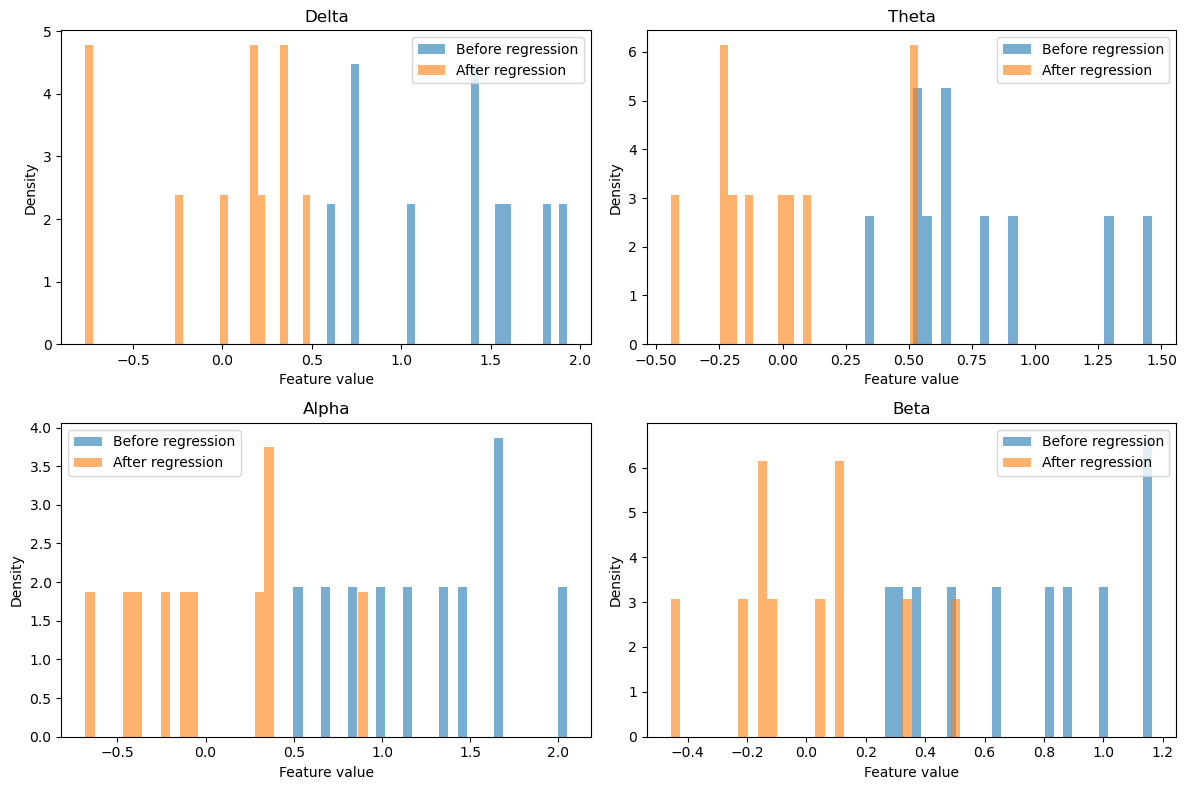

In [17]:
# ==============================================
# DISTRIBUTION PRESERVATION CHECK
# Raw vs Age-Regressed EEG Features
# ==============================================

import matplotlib.pyplot as plt
import numpy as np

# Configuration
BANDS = ["delta_power", "theta_power", "alpha_power", "beta_power"]

# Use same dataframe with residuals already computed
df = analysis_df[["Age"] + BANDS].dropna().copy()

# Recompute residuals safely (idempotent)
import statsmodels.api as sm
for band in BANDS:
    X = sm.add_constant(df["Age"])
    model = sm.OLS(df[band], X).fit()
    df[f"{band}_age_resid"] = model.resid

# --------------------------------
# Plot distributions
# --------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, band in zip(axes, BANDS):
    ax.hist(df[band], bins=30, alpha=0.6, density=True, label="Before regression")
    ax.hist(df[f"{band}_age_resid"], bins=30, alpha=0.6, density=True, label="After regression")
    
    ax.set_title(band.replace("_power", "").capitalize())
    ax.set_xlabel("Feature value")
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()


In [23]:
import pandas as pd

# Load standard CAM-CAN metadata
std_path = r"C:\Menopause\CAMCAN\standard_data.csv"
std_df = pd.read_csv(std_path)

# Count by sex
sex_counts = std_df["Sex"].value_counts()
print(sex_counts)

# Subset women only
women_df = std_df[std_df["Sex"] == "FEMALE"].copy()

print("\nNumber of women:", women_df.shape[0])

# Age statistics for women
women_age_summary = women_df["Age"].describe()
women_age_summary


Sex
FEMALE    1508
MALE      1173
Name: count, dtype: int64

Number of women: 1508


count    1508.000000
mean       60.959615
std        21.457445
min        18.500000
25%        41.560000
50%        63.625000
75%        80.420000
max       102.170000
Name: Age, dtype: float64

In [24]:
import numpy as np

women_df = women_df.copy()

women_df["Age_group"] = pd.cut(
    women_df["Age"],
    bins=[0, 40, 60, 120],
    labels=["Young", "Middle", "Older"]
)

women_df["Age_group"].value_counts()


Age_group
Older     835
Young     355
Middle    318
Name: count, dtype: int64

In [34]:
import pandas as pd
from scipy.stats import skew, kurtosis

# --------------------------------------------------
# STEP 0: USE YOUR EXISTING DATAFRAME
# --------------------------------------------------
# If your dataframe has a different name, change ONLY this line
df = analysis_df.copy()

# --------------------------------------------------
# STEP 1: DEFINE EEG BANDS
# --------------------------------------------------
bands_before = [
    "delta_power",
    "theta_power",
    "alpha_power",
    "beta_power"
]

bands_after = [
    "delta_power_age_resid",
    "theta_power_age_resid",
    "alpha_power_age_resid",
    "beta_power_age_resid"
]

# --------------------------------------------------
# STEP 2: COMPUTE DISTRIBUTION STATISTICS
# --------------------------------------------------
rows = []

for b_before, b_after in zip(bands_before, bands_after):
    rows.append({
        "Band": b_before.replace("_power", "").capitalize(),
        "Mean_before": df[b_before].mean(),
        "Mean_after": df[b_after].mean(),
        "Std_before": df[b_before].std(),
        "Std_after": df[b_after].std(),
        "Skew_before": skew(df[b_before], nan_policy="omit"),
        "Skew_after": skew(df[b_after], nan_policy="omit"),
        "Kurtosis_before": kurtosis(df[b_before], nan_policy="omit"),
        "Kurtosis_after": kurtosis(df[b_after], nan_policy="omit"),
    })

dist_df = pd.DataFrame(rows)

# --------------------------------------------------
# STEP 3: DISPLAY RESULT
# --------------------------------------------------
print("\n📊 DISTRIBUTION PRESERVATION CHECK (BEFORE vs AFTER REGRESSION)\n")
display(dist_df.round(4))



📊 DISTRIBUTION PRESERVATION CHECK (BEFORE vs AFTER REGRESSION)



,Band,Mean_before,Mean_after,Std_before,Std_after,Skew_before,Skew_after,Kurtosis_before,Kurtosis_after
0,Delta,1.2802,-0.0,0.4738,0.4441,-0.2225,-0.8486,-1.3475,-0.6965
1,Theta,0.7743,-0.0,0.3628,0.3224,0.8291,0.6550,-0.4751,-0.6115
2,Alpha,1.2408,-0.0,0.4911,0.4811,0.0336,0.4373,-1.0375,-0.6084
3,Beta,0.7093,0.0,0.3431,0.2832,0.0229,0.3081,-1.4645,-0.4858


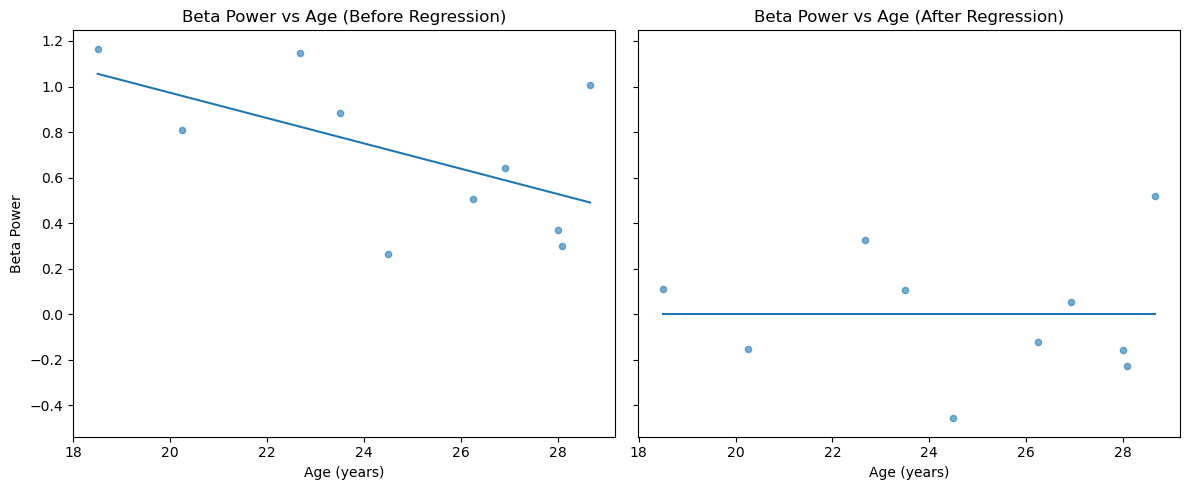

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------
# STEP 1: COPY DATA (SAFE PRACTICE)
# --------------------------------------------------
df = analysis_df.copy()

# --------------------------------------------------
# STEP 2: CREATE FIGURE
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# -------- BEFORE REGRESSION --------
axes[0].scatter(
    df["Age"],
    df["beta_power"],
    alpha=0.6,
    s=20
)

# regression line
coef_before = np.polyfit(df["Age"], df["beta_power"], 1)
x_vals = np.array([df["Age"].min(), df["Age"].max()])
axes[0].plot(x_vals, coef_before[0]*x_vals + coef_before[1])

axes[0].set_title("Beta Power vs Age (Before Regression)")
axes[0].set_xlabel("Age (years)")
axes[0].set_ylabel("Beta Power")

# -------- AFTER REGRESSION --------
axes[1].scatter(
    df["Age"],
    df["beta_power_age_resid"],
    alpha=0.6,
    s=20
)

coef_after = np.polyfit(df["Age"], df["beta_power_age_resid"], 1)
axes[1].plot(x_vals, coef_after[0]*x_vals + coef_after[1])

axes[1].set_title("Beta Power vs Age (After Regression)")
axes[1].set_xlabel("Age (years)")

# --------------------------------------------------
# STEP 3: FINAL TOUCH
# --------------------------------------------------
plt.tight_layout()
plt.show()


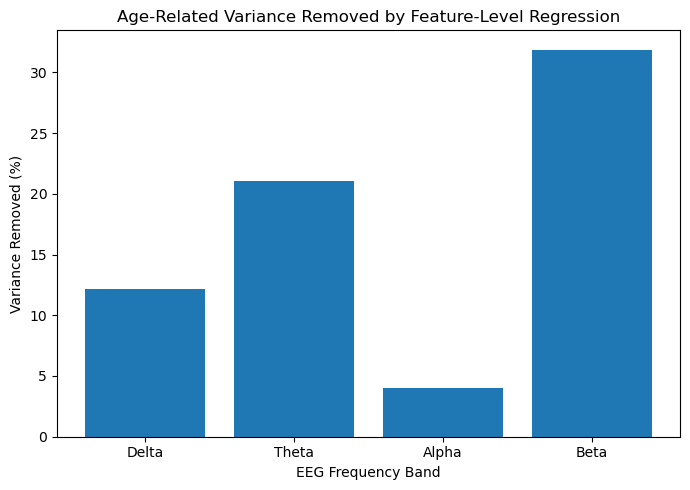

In [36]:
import matplotlib.pyplot as plt

# -----------------------------------------
# STEP 1: MANUALLY DEFINE VARIANCE REMOVED
# -----------------------------------------
bands = ["Delta", "Theta", "Alpha", "Beta"]
variance_removed = [12.15, 21.07, 4.03, 31.86]

# -----------------------------------------
# STEP 2: CREATE BAR PLOT
# -----------------------------------------
plt.figure(figsize=(7, 5))
plt.bar(bands, variance_removed)

plt.ylabel("Variance Removed (%)")
plt.xlabel("EEG Frequency Band")
plt.title("Age-Related Variance Removed by Feature-Level Regression")

plt.tight_layout()
plt.show()


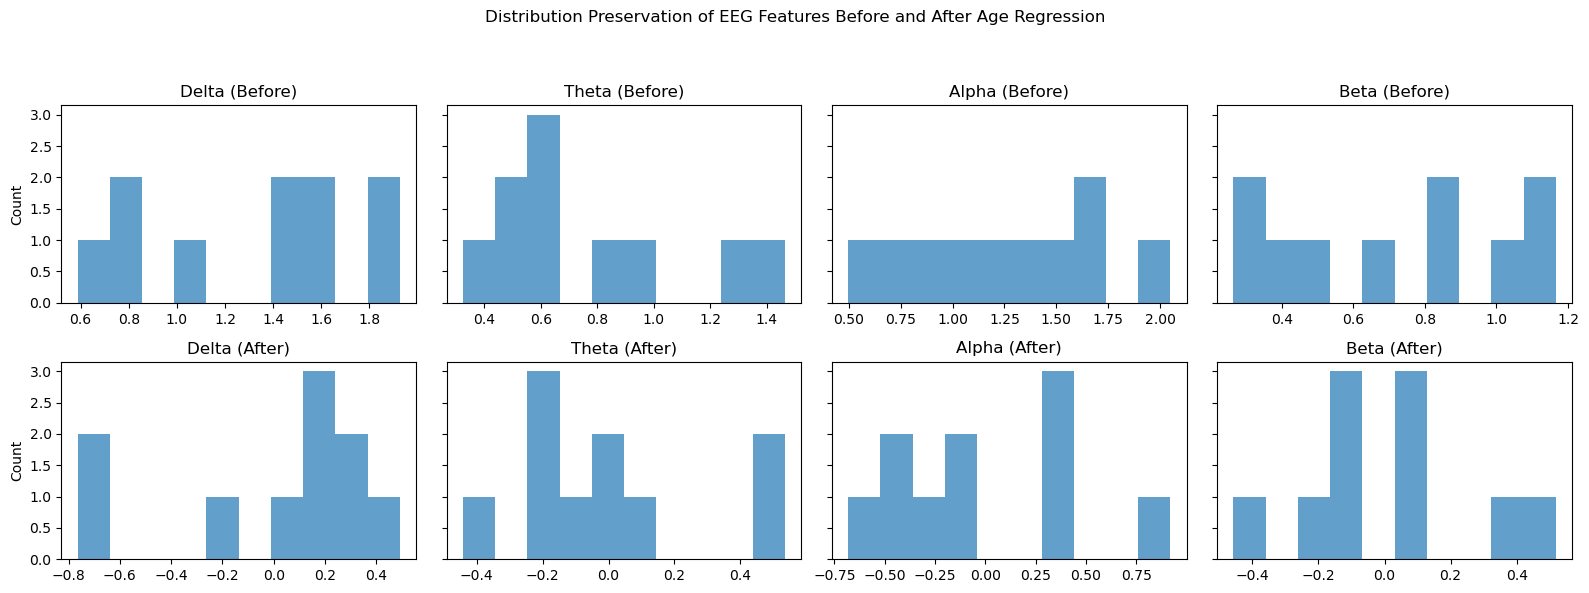

In [37]:
import matplotlib.pyplot as plt

bands = [
    ("delta_power", "delta_power_age_resid", "Delta"),
    ("theta_power", "theta_power_age_resid", "Theta"),
    ("alpha_power", "alpha_power_age_resid", "Alpha"),
    ("beta_power",  "beta_power_age_resid",  "Beta"),
]

fig, axes = plt.subplots(2, 4, figsize=(16, 6), sharey=True)

for i, (before, after, label) in enumerate(bands):
    # Before regression
    axes[0, i].hist(
        analysis_df[before],
        bins=10,
        alpha=0.7
    )
    axes[0, i].set_title(f"{label} (Before)")
    
    # After regression
    axes[1, i].hist(
        analysis_df[after],
        bins=10,
        alpha=0.7
    )
    axes[1, i].set_title(f"{label} (After)")

axes[0, 0].set_ylabel("Count")
axes[1, 0].set_ylabel("Count")

plt.suptitle("Distribution Preservation of EEG Features Before and After Age Regression")
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


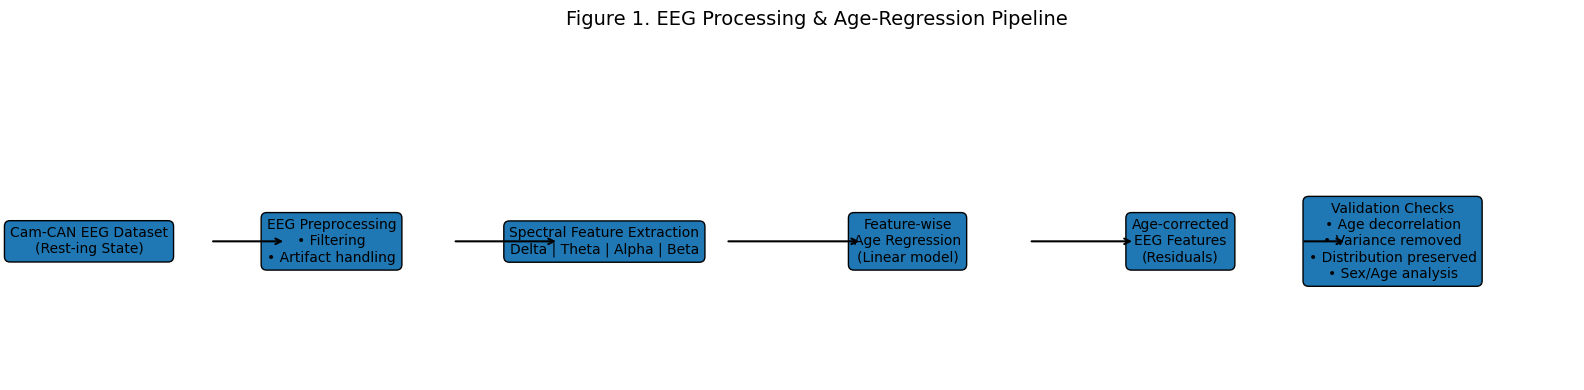

In [38]:
import matplotlib.pyplot as plt

# Create figure
fig, ax = plt.subplots(figsize=(16, 4))
ax.axis("off")

# Box positions
boxes = [
    (0.02, 0.4, "Cam-CAN EEG Dataset\n(Rest-ing State)"),
    (0.18, 0.4, "EEG Preprocessing\n• Filtering\n• Artifact handling"),
    (0.36, 0.4, "Spectral Feature Extraction\nDelta | Theta | Alpha | Beta"),
    (0.56, 0.4, "Feature-wise\nAge Regression\n(Linear model)"),
    (0.74, 0.4, "Age-corrected\nEEG Features\n(Residuals)"),
    (0.88, 0.4, "Validation Checks\n• Age decorrelation\n• Variance removed\n• Distribution preserved\n• Sex/Age analysis")
]

# Draw boxes
for x, y, text in boxes:
    ax.text(
        x, y, text,
        ha="center", va="center",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.4", edgecolor="black")
    )

# Draw arrows
for i in range(len(boxes) - 1):
    ax.annotate(
        "",
        xy=(boxes[i+1][0] - 0.03, 0.4),
        xytext=(boxes[i][0] + 0.08, 0.4),
        arrowprops=dict(arrowstyle="->", lw=1.5)
    )

plt.title("Figure 1. EEG Processing & Age-Regression Pipeline", fontsize=14)
plt.tight_layout()
plt.show()


✅ All required columns found


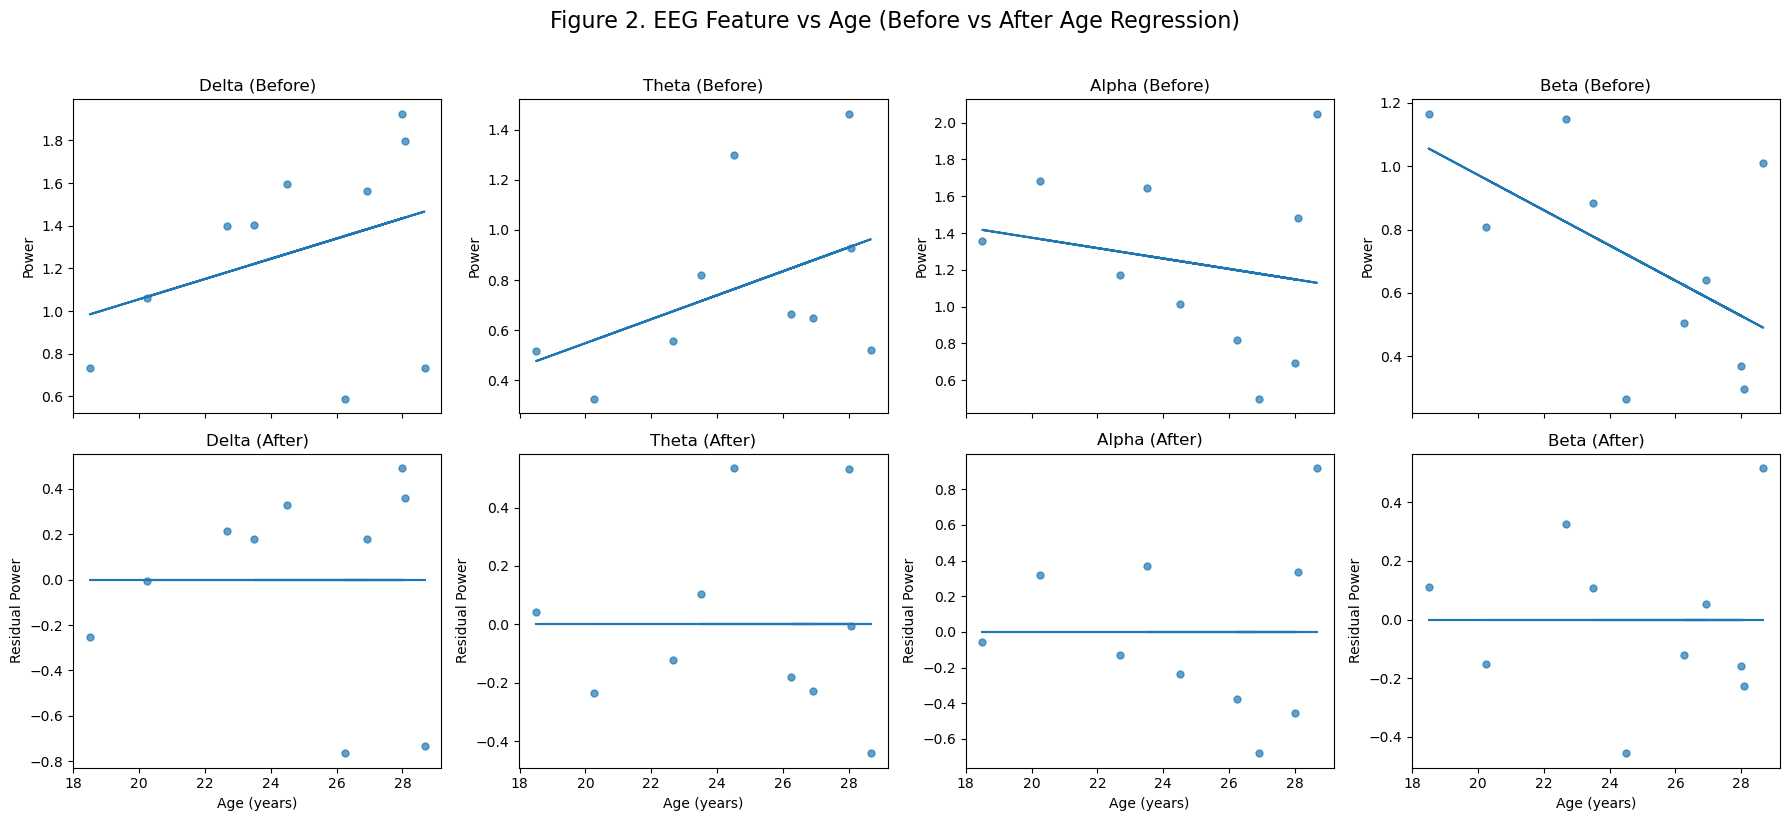

In [39]:
# ============================================================
# FIGURE 2: EEG Feature vs Age (Before vs After Regression)
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ------------------------------------------------------------
# STEP 1: LOAD DATA (EDIT PATH ONLY IF NEEDED)
# ------------------------------------------------------------
path = r"C:\Menopause\CAMCAN\standard_data.csv"   # metadata if needed
# analysis_df should ALREADY be in memory from your EEG pipeline
# If not, uncomment below and load your EEG dataframe
# analysis_df = pd.read_csv("YOUR_EEG_FEATURE_FILE.csv")

# ------------------------------------------------------------
# STEP 2: REQUIRED COLUMNS CHECK
# ------------------------------------------------------------
REQUIRED_COLS = [
    "Age",
    "delta_power", "theta_power", "alpha_power", "beta_power",
    "delta_power_age_resid", "theta_power_age_resid",
    "alpha_power_age_resid", "beta_power_age_resid"
]

missing = [c for c in REQUIRED_COLS if c not in analysis_df.columns]
if missing:
    raise RuntimeError(f"❌ Missing columns in analysis_df: {missing}")

print("✅ All required columns found")

# ------------------------------------------------------------
# STEP 3: DEFINE BANDS
# ------------------------------------------------------------
bands_before = [
    "delta_power", "theta_power", "alpha_power", "beta_power"
]
bands_after = [
    "delta_power_age_resid", "theta_power_age_resid",
    "alpha_power_age_resid", "beta_power_age_resid"
]
band_labels = ["Delta", "Theta", "Alpha", "Beta"]

# ------------------------------------------------------------
# STEP 4: PLOTTING
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 4, figsize=(18, 8), sharex=True)

for i, (b_before, b_after) in enumerate(zip(bands_before, bands_after)):
    
    # -------- BEFORE REGRESSION --------
    x = analysis_df["Age"]
    y = analysis_df[b_before]
    
    slope, intercept, _, _, _ = linregress(x, y)
    axes[0, i].scatter(x, y, s=25, alpha=0.7)
    axes[0, i].plot(x, intercept + slope * x)
    axes[0, i].set_title(f"{band_labels[i]} (Before)")
    axes[0, i].set_ylabel("Power")
    
    # -------- AFTER REGRESSION --------
    y_res = analysis_df[b_after]
    
    slope_r, intercept_r, _, _, _ = linregress(x, y_res)
    axes[1, i].scatter(x, y_res, s=25, alpha=0.7)
    axes[1, i].plot(x, intercept_r + slope_r * x)
    axes[1, i].set_title(f"{band_labels[i]} (After)")
    axes[1, i].set_ylabel("Residual Power")
    axes[1, i].set_xlabel("Age (years)")

plt.suptitle(
    "Figure 2. EEG Feature vs Age (Before vs After Age Regression)",
    fontsize=16,
    y=1.02
)
plt.tight_layout()
plt.show()


✅ EEG columns verified


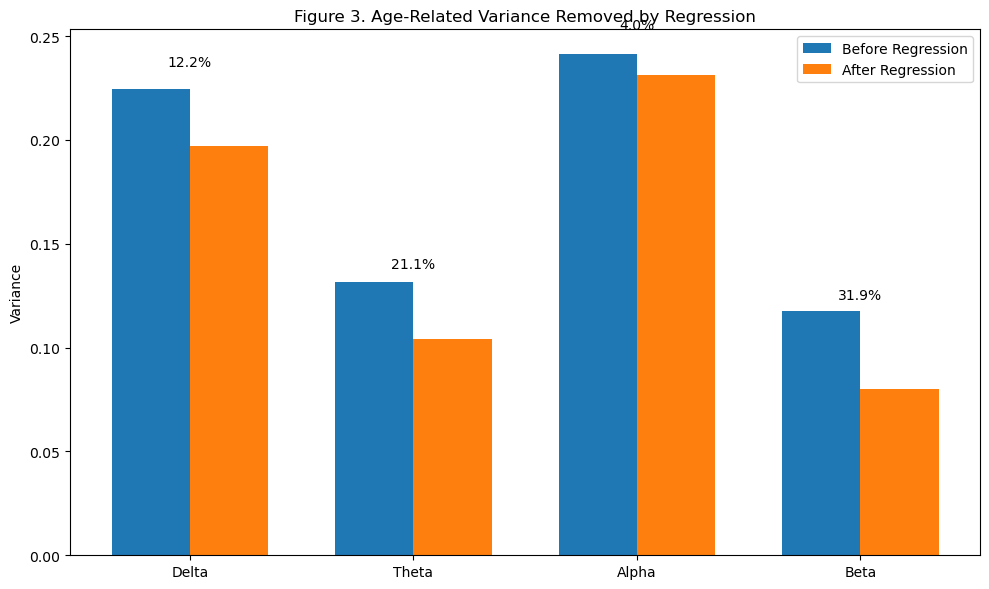

In [40]:
# ============================================================
# FIGURE 3: Age-Related Variance Removed by Regression
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# STEP 1: REQUIRED COLUMNS CHECK
# ------------------------------------------------------------
bands_before = [
    "delta_power", "theta_power", "alpha_power", "beta_power"
]
bands_after = [
    "delta_power_age_resid", "theta_power_age_resid",
    "alpha_power_age_resid", "beta_power_age_resid"
]
band_labels = ["Delta", "Theta", "Alpha", "Beta"]

required = bands_before + bands_after
missing = [c for c in required if c not in analysis_df.columns]
if missing:
    raise RuntimeError(f"❌ Missing EEG columns: {missing}")

print("✅ EEG columns verified")

# ------------------------------------------------------------
# STEP 2: COMPUTE VARIANCE
# ------------------------------------------------------------
var_before = [analysis_df[b].var() for b in bands_before]
var_after  = [analysis_df[b].var() for b in bands_after]

var_removed_pct = [
    100 * (vb - va) / vb if vb > 0 else 0
    for vb, va in zip(var_before, var_after)
]

# ------------------------------------------------------------
# STEP 3: BAR PLOT
# ------------------------------------------------------------
x = np.arange(len(band_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width/2, var_before, width, label="Before Regression")
ax.bar(x + width/2, var_after,  width, label="After Regression")

# Annotate % removed
for i, pct in enumerate(var_removed_pct):
    ax.text(
        x[i],
        max(var_before[i], var_after[i]) * 1.05,
        f"{pct:.1f}%",
        ha="center",
        fontsize=10
    )

ax.set_xticks(x)
ax.set_xticklabels(band_labels)
ax.set_ylabel("Variance")
ax.set_title("Figure 3. Age-Related Variance Removed by Regression")
ax.legend()

plt.tight_layout()
plt.show()


✅ EEG columns verified for Figure 4


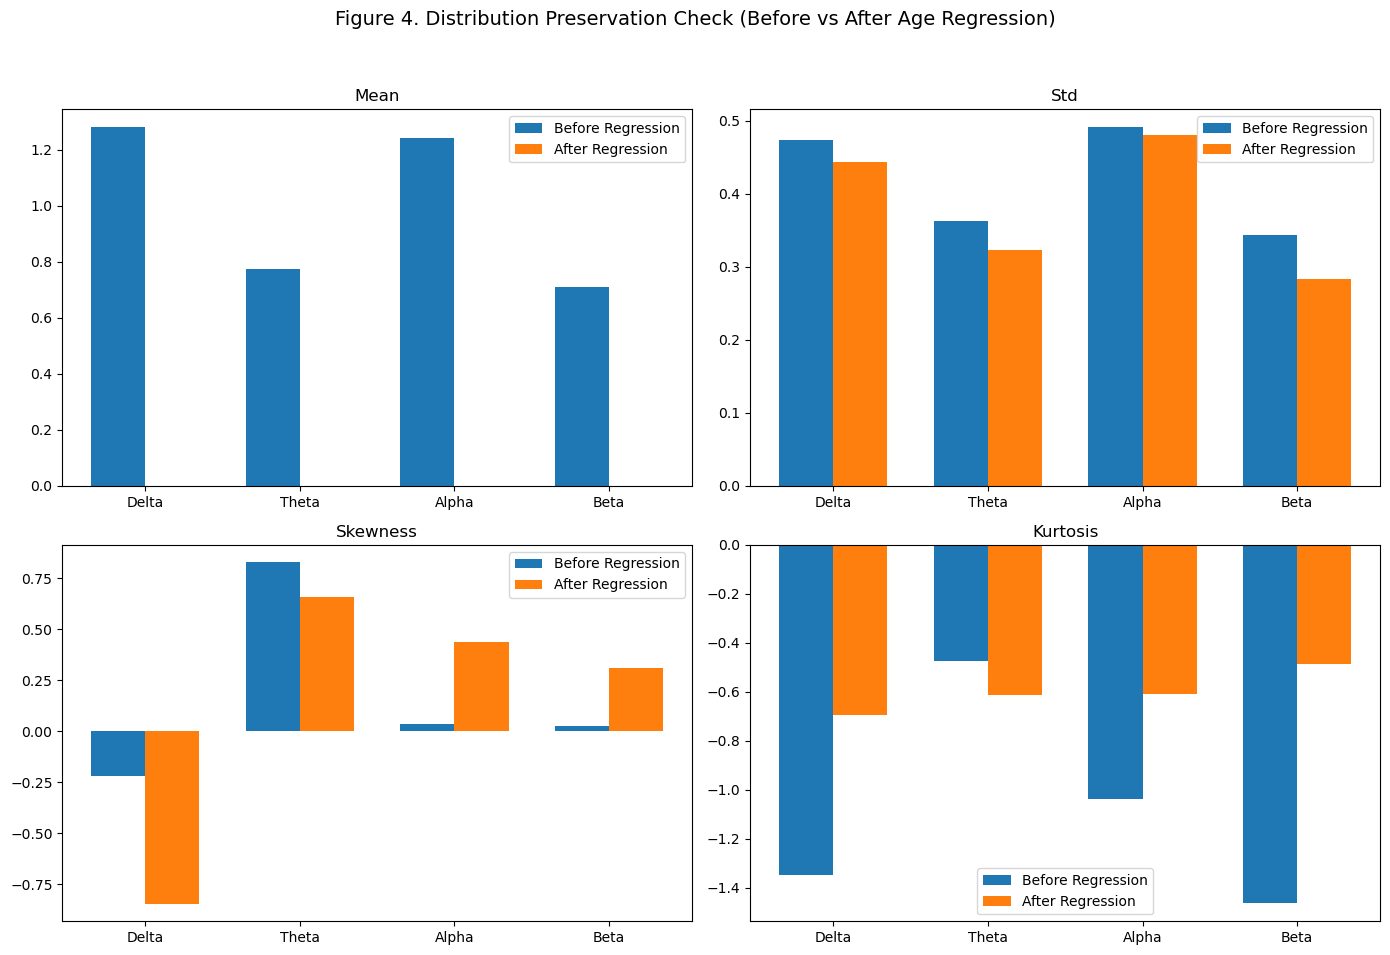

In [41]:
# ============================================================
# FIGURE 4: Distribution Preservation Check
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# ------------------------------------------------------------
# STEP 1: DEFINE EEG BANDS
# ------------------------------------------------------------
bands_before = [
    "delta_power", "theta_power", "alpha_power", "beta_power"
]
bands_after = [
    "delta_power_age_resid", "theta_power_age_resid",
    "alpha_power_age_resid", "beta_power_age_resid"
]
band_labels = ["Delta", "Theta", "Alpha", "Beta"]

# Safety check
missing = [c for c in bands_before + bands_after if c not in analysis_df.columns]
if missing:
    raise RuntimeError(f"❌ Missing columns: {missing}")

print("✅ EEG columns verified for Figure 4")

# ------------------------------------------------------------
# STEP 2: COMPUTE DISTRIBUTION METRICS
# ------------------------------------------------------------
metrics = {
    "Mean": [],
    "Std": [],
    "Skewness": [],
    "Kurtosis": []
}

metrics_after = {
    "Mean": [],
    "Std": [],
    "Skewness": [],
    "Kurtosis": []
}

for b_before, b_after in zip(bands_before, bands_after):
    x = analysis_df[b_before]
    y = analysis_df[b_after]

    metrics["Mean"].append(x.mean())
    metrics["Std"].append(x.std())
    metrics["Skewness"].append(skew(x))
    metrics["Kurtosis"].append(kurtosis(x))

    metrics_after["Mean"].append(y.mean())
    metrics_after["Std"].append(y.std())
    metrics_after["Skewness"].append(skew(y))
    metrics_after["Kurtosis"].append(kurtosis(y))

# ------------------------------------------------------------
# STEP 3: PLOT
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

metric_names = ["Mean", "Std", "Skewness", "Kurtosis"]

for i, metric in enumerate(metric_names):
    ax = axes[i]
    x = np.arange(len(band_labels))
    width = 0.35

    ax.bar(x - width/2, metrics[metric], width, label="Before Regression")
    ax.bar(x + width/2, metrics_after[metric], width, label="After Regression")

    ax.set_xticks(x)
    ax.set_xticklabels(band_labels)
    ax.set_title(metric)
    ax.legend()

fig.suptitle(
    "Figure 4. Distribution Preservation Check (Before vs After Age Regression)",
    fontsize=14
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [46]:
# ============================================================
# TABLE 1: Dataset Characteristics (Cam-CAN EEG Subsample)
# ============================================================

import pandas as pd

# ------------------------------------------------------------
# STEP 1: LOAD STANDARD DEMOGRAPHIC DATA
# ------------------------------------------------------------
std_path = r"C:\Menopause\CAMCAN\standard_data.csv"
demo_df = pd.read_csv(std_path)

# Required columns check
required_cols = ["Age", "Sex"]
missing = [c for c in required_cols if c not in demo_df.columns]
if missing:
    raise RuntimeError(f"❌ Missing required columns in standard_data.csv: {missing}")

print("✅ Demographic columns found")

# ------------------------------------------------------------
# STEP 2: BASIC COUNTS
# ------------------------------------------------------------
total_n = len(demo_df)
sex_counts = demo_df["Sex"].value_counts()

n_women = sex_counts.get("FEMALE", 0)
n_men   = sex_counts.get("MALE", 0)

# ------------------------------------------------------------
# STEP 3: AGE STATISTICS
# ------------------------------------------------------------
age_min = demo_df["Age"].min()
age_max = demo_df["Age"].max()
age_mean = demo_df["Age"].mean()
age_std = demo_df["Age"].std()

# ------------------------------------------------------------
# STEP 4: AGE GROUPING
# ------------------------------------------------------------
def age_group(age):
    if age < 40:
        return "Young"
    elif age < 60:
        return "Middle"
    else:
        return "Older"

demo_df["Age_group"] = demo_df["Age"].apply(age_group)
age_group_counts = demo_df["Age_group"].value_counts()

# ------------------------------------------------------------
# STEP 5: BUILD TABLE 1
# ------------------------------------------------------------
table1 = pd.DataFrame({
    "Metric": [
        "Total participants (N)",
        "Women (N)",
        "Men (N)",
        "Age range (years)",
        "Mean age ± SD",
        "Young (Age < 40)",
        "Middle (40 ≤ Age < 60)",
        "Older (Age ≥ 60)"
    ],
    "Value": [
        total_n,
        n_women,
        n_men,
        f"{age_min:.2f} – {age_max:.2f}",
        f"{age_mean:.2f} ± {age_std:.2f}",
        age_group_counts.get("Young", 0),
        age_group_counts.get("Middle", 0),
        age_group_counts.get("Older", 0)
    ]
})

table1


✅ Demographic columns found


,Metric,Value
0,Total participants (N),2681
1,Women (N),1508
2,Men (N),1173
3,Age range (years),18.50 – 102.17
4,Mean age ± SD,60.57 ± 20.93
5,Young (Age < 40),613
6,Middle (40 ≤ Age < 60),597
7,Older (Age ≥ 60),1471


In [47]:
# ============================================================
# TABLE 2: EEG Feature Distribution Statistics
# ============================================================

import pandas as pd
from scipy.stats import skew, kurtosis

# ------------------------------------------------------------
# STEP 1: DEFINE EEG BANDS
# ------------------------------------------------------------
bands = {
    "Delta": ("delta_power", "delta_power_age_resid"),
    "Theta": ("theta_power", "theta_power_age_resid"),
    "Alpha": ("alpha_power", "alpha_power_age_resid"),
    "Beta":  ("beta_power",  "beta_power_age_resid"),
}

# ------------------------------------------------------------
# STEP 2: COLUMN CHECK
# ------------------------------------------------------------
all_cols = [c for pair in bands.values() for c in pair]
missing = [c for c in all_cols if c not in analysis_df.columns]
if missing:
    raise RuntimeError(f"❌ Missing EEG columns: {missing}")

print("✅ EEG columns found")

# ------------------------------------------------------------
# STEP 3: COMPUTE DISTRIBUTION STATISTICS
# ------------------------------------------------------------
rows = []

for band, (before_col, after_col) in bands.items():
    before = analysis_df[before_col].dropna()
    after  = analysis_df[after_col].dropna()

    rows.append({
        "Band": band,
        "Mean (Before)": before.mean(),
        "Mean (After)": after.mean(),
        "Std (Before)": before.std(),
        "Std (After)": after.std(),
        "Skewness (Before)": skew(before),
        "Skewness (After)": skew(after),
        "Kurtosis (Before)": kurtosis(before),
        "Kurtosis (After)": kurtosis(after),
    })

table2 = pd.DataFrame(rows)

table2


✅ EEG columns found


,Band,Mean (Before),Mean (After),Std (Before),Std (After),Skewness (Before),Skewness (After),Kurtosis (Before),Kurtosis (After)
0,Delta,1.280205,-6.217249e-16,0.473798,0.444080,-0.222491,-0.848638,-1.347470,-0.696454
1,Theta,0.774321,-4.662937e-16,0.362845,0.322370,0.829070,0.655010,-0.475119,-0.611522
2,Alpha,1.240813,-5.329071e-16,0.491105,0.481117,0.033596,0.437290,-1.037475,-0.608420
3,Beta,0.709271,4.940492e-16,0.343095,0.283208,0.022949,0.308103,-1.464473,-0.485764
